RFM analysis is a marketing technique used to quantitatively determine who the best customers are by looking at what date a customer bought (recency), how often they buy (frequency) and how much the customer is spending (in money). In RFM analysis, RFM stands for recency, frequency, and monetary.

### RFM Analysis
In this article, I will introduce you to a data science task on RFM analysis using Python. Let’s do an RFM analysis using retail data. It contains customer-level data on transactions by date. He also obtained information on responses to a promotional campaign conducted by the organization. Now let’s start with importing the necessary libraries:

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

Now let’s read the dataset using the pandas package in python:

In [2]:
df = pd.read_csv(r'C:\Users\SHREE\Downloads\Python CODES\RFM Analysis with Python\Retail_Data_Transactions.csv', parse_dates=['trans_date'])

Suppose the study is performed from 01 / April / 2015. We will identify the oldest and most recent transaction dates:

In [3]:
print(df['trans_date'].min(), df['trans_date'].max())

2011-05-16 00:00:00 2015-03-16 00:00:00


The number of days from the date of the study is calculated as below:

In [4]:
sd = dt.datetime(2015,4,1)
df['hist']=sd - df['trans_date']
df['hist'].astype('timedelta64[D]')
df['hist']=df['hist'] / np.timedelta64(1, 'D')

Only transactions carried out in the last 2 years are taken into account for the RFM analysis:

In [5]:
df=df[df['hist'] < 730]

The data will be summarized at the customer level by taking the number of days until the last transaction, the sum of the total transaction amount and the total transaction number:

In [6]:
rfmTable = df.groupby('customer_id').agg({'hist': lambda x:x.min(), # Recency
                                        'customer_id': lambda x: len(x),               # Frequency
                                        'tran_amount': lambda x: x.sum()})          # Monetary Value

rfmTable.rename(columns={'hist': 'recency', 
                         'customer_id': 'frequency', 
                         'tran_amount': 'monetary_value'}, inplace=True)

RFM analysis consists of classifying R, F and M into 3 or more categories. For simplicity, I will create 4 categories based on the quartiles:

In [7]:
quartiles = rfmTable.quantile(q=[0.25,0.50,0.75])

Let’s convert the quartile information into a dictionary so that the thresholds can be raised:

In [8]:
quartiles=quartiles.to_dict()

In the case of recency, the lower the better and therefore our categorization system must be reversed:

In [9]:
def RClass(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
## for Frequency and Monetary value 

def FMClass(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
rfmSeg = rfmTable
rfmSeg['R_Quartile'] = rfmSeg['recency'].apply(RClass, args=('recency',quartiles,))
rfmSeg['F_Quartile'] = rfmSeg['frequency'].apply(FMClass, args=('frequency',quartiles,))
rfmSeg['M_Quartile'] = rfmSeg['monetary_value'].apply(FMClass, args=('monetary_value',quartiles,))

For RFM analysis, it is essential to combine scores to create a single score. There are a few approaches. One simple way is to join the scores to create a 3-digit number between 111 and 444. The downside here is too many categories (4x4x4). Also, not easy to prioritize scores like 421 versus 412:

In [11]:
rfmSeg['RFMClass'] = rfmSeg.R_Quartile.map(str) + rfmSeg.F_Quartile.map(str) + rfmSeg.M_Quartile.map(str)
rfmSeg.sort_values(by=['RFMClass', 'monetary_value'], ascending=[True, False])

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
customer_id,,,,,,,
CS4640,34.0,21,1610,1,1,1,111
CS5343,29.0,20,1585,1,1,1,111
CS3622,29.0,20,1549,1,1,1,111
CS2316,19.0,21,1446,1,1,1,111
CS3270,19.0,20,1436,1,1,1,111
...,...,...,...,...,...,...,...
CS8033,499.0,1,24,4,4,4,444
CS8400,462.0,1,19,4,4,4,444
CS8760,463.0,1,19,4,4,4,444


Another possibility is to combine the scores to create a score (eg 4 + 1 + 1). Here the advantage is that each of the scores has the same importance. However, some scores will have many locations as constituents (eg – 413 and 431):

In [12]:
rfmSeg['Total Score'] = rfmSeg['R_Quartile'] + rfmSeg['F_Quartile'] +rfmSeg['M_Quartile']

Let’s check how the combined score arranges R, F and M:

<AxesSubplot:xlabel='Total Score'>

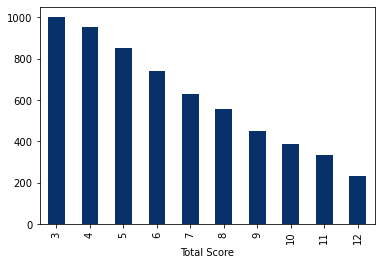

In [13]:
rfmSeg.groupby('Total Score').agg('monetary_value').mean().plot(kind='bar', colormap='Blues_r')

<AxesSubplot:xlabel='Total Score'>

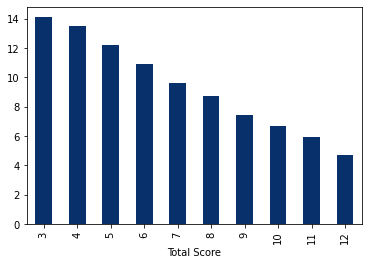

In [14]:
rfmSeg.groupby('Total Score').agg('frequency').mean().plot(kind='bar', colormap='Blues_r')

The ultimate test of the RFM analysis is the impact on any consumer behaviour. Let’s check its impact on customer response to a promotional campaign:

Text(0, 0.5, 'Proportion of Responders')

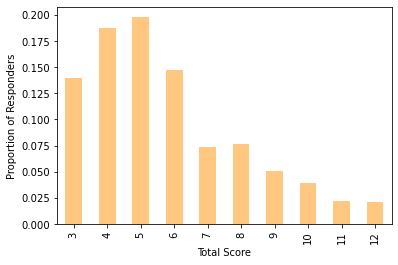

In [15]:
res = pd.read_csv(r'C:\Users\SHREE\Downloads\Python CODES\RFM Analysis with Python\Retail_Data_Response.csv')
res.sort_values('customer_id', inplace=True)
rfmSeg.reset_index(inplace=True)
rfmSeg.sort_values('customer_id', inplace=True)
rfm2=pd.merge(rfmSeg, res, on='customer_id')

ax=rfm2.groupby('Total Score').agg('response').mean().plot(kind='bar', colormap='copper_r')
ax.set_xlabel("Total Score")
ax.set_ylabel("Proportion of Responders")

The graph shows that response behaviour is strongly related to the combined score. However, there is not much difference between scores of 3,4,5 and 6. While the performance of RFM scores is much lower for scores greater than 6.